In [ ]:
# set parameters
# Time horizon
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt


T = 10
# Cost
c = 1.0
# Revenue from selling a unit of product
h = 1.0
# Penalty for not meeting demand
p = 10.0
# Discount factor
gamma = 0.98
# Probability of a customer purchasing if visiting
p_hat = 3.0 / 4.0
# Number of trials (possible customers)
n = 27

binomial_pdf = {x: binom.pmf(x, n, p_hat) for x in range(n + 1)}

x_range = np.array(range(-27 * 2, (27 + 1) * 2))

In [ ]:
# 1a
def get_dp(
    T: int = T,
    h_t_plus_t=h,
    p_t_plus_t=p,
    gamma=gamma,
    binomial_pdf=binomial_pdf,
    x_range=x_range,
    K=0,
):
    # Compute theta_{T+1}(x)
    theta = {T + 1: {x: h_t_plus_t * x if x >= 0 else -p_t_plus_t * x for x in x_range}}
    theta.update({t: {} for t in range(1, T + 1)})

    y_t = {t: {} for t in range(1, T + 1)}

    def g(y: int):
        n_y_bar = np.sum(
            [(y - d) * binomial_pdf.get(d, 0) for d in range(0, max(y, 0))]
        )
        n_y = np.sum(
            [(d - y) * binomial_pdf.get(d, 0) for d in range(max(y, 0), n + 1)]
        )
        return h * n_y_bar + p * n_y

    def E_D_minus(theta_t_plus_1: dict, y: int):
        return np.sum(
            [
                binomial_pdf[d]
                * theta_t_plus_1.get(
                    y - d, h * (y - d) * (y - d > 0) + p * (d - y) * (d - y > 0)
                )
                for d in range(0, n + 1)
            ]
        )

    # 2. Compute theta_t(x) for t = T,...,1
    for t in range(T, 0, -1):
        for x in x_range:
            min_list = [
                K * (y - x > 0)
                + c * (y - x)
                + g(y)
                + gamma * E_D_minus(theta[t + 1], y)
                for y in x_range
                if y >= x
            ]
            theta[t][x] = np.min(min_list)
            y_t[t][x] = np.argmin(min_list) + x

    return theta, y_t

S_1^*=23
S_2^*=23
S_3^*=23
S_4^*=23
S_5^*=23
S_6^*=23
S_7^*=23
S_8^*=23
S_9^*=23
S_10^*=23


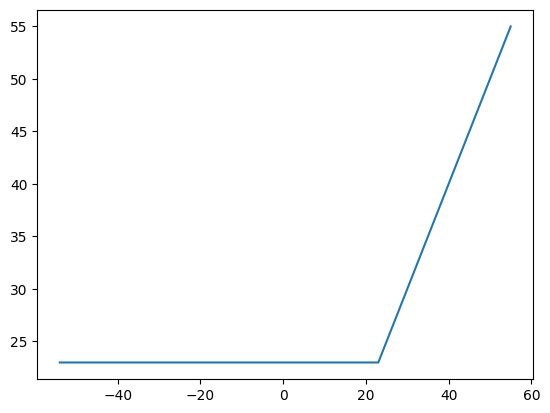

In [ ]:
# 1b,c
# Plot the y_t for a specific t over x_range
theta, y_t = get_dp()
for t in range(1, T + 1):
    print(f"S_{t}^*={y_t[t][np.min(x_range)]}")
plt.plot(x_range, [y_t[7][x] for x in x_range])

S_1^*=23
S_2^*=23
S_3^*=23
S_4^*=23
S_5^*=23
S_6^*=23
S_7^*=23
S_8^*=23
S_9^*=23
S_10^*=22


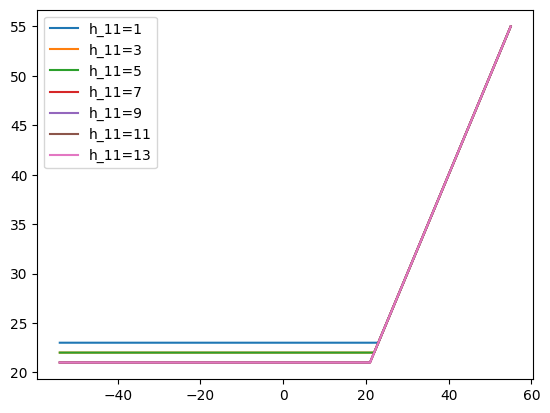

In [ ]:
# If h_{T+1} increases we will want to keep less stock in the end, as the penalty for overstocking is higher
theta, y_t = get_dp(h_t_plus_t=2)
for t in range(1, T + 1):
    print(f"S_{t}^*={y_t[t][np.min(x_range)]}")
for h_t_plus_1 in range(1, 15, 2):
    theta, y_t = get_dp(h_t_plus_t=h_t_plus_1)
    plt.plot(x_range, [y_t[10][x] for x in x_range], label=f"h_{T+1}={h_t_plus_1}")
plt.legend()

S_1^*=23
S_2^*=23
S_3^*=23
S_4^*=23
S_5^*=23
S_6^*=23
S_7^*=23
S_8^*=23
S_9^*=23
S_10^*=23


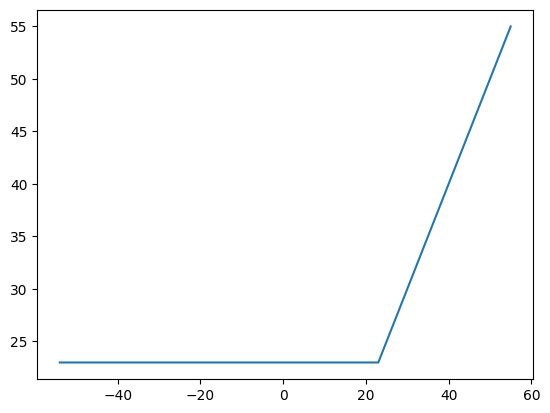

In [ ]:
theta, y_t = get_dp(gamma=0.5)
for t in range(1, T + 1):
    print(f"S_{t}^*={y_t[t][np.min(x_range)]}")
plt.plot(x_range, [y_t[7][x] for x in x_range])

# Question 2

S*_1 = 43  s*_1 =17
S*_2 = 43  s*_2 =16
S*_3 = 43  s*_3 =17
S*_4 = 43  s*_4 =16
S*_5 = 43  s*_5 =17
S*_6 = 43  s*_6 =16
S*_7 = 43  s*_7 =17
S*_8 = 43  s*_8 =16
S*_9 = 43  s*_9 =17
S*_10= 23  s*_10=17


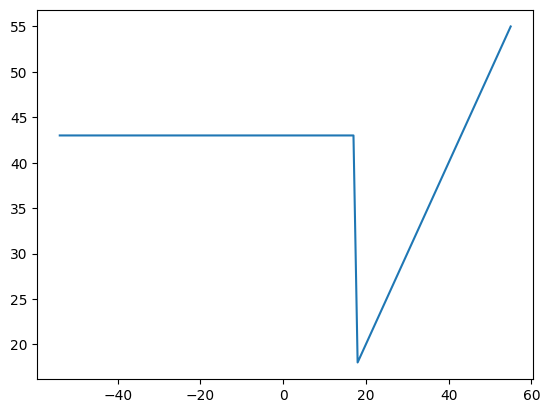

In [ ]:
theta, y_t = get_dp(K=40)
for t in range(1, T + 1):
    S_t = y_t[t][np.min(x_range)]
    # get index of the last element that is equal to S_t
    for x in x_range:
        if y_t[t][x] == S_t:
            s_t = x
        else:
            break
    print(f"S*_{t:<2}={S_t:^4} s*_{t:<2}={s_t}")
plt.plot(x_range, [y_t[7][x] for x in x_range])

S*_1 = 43  s*_1 =16
S*_2 = 43  s*_2 =12
S*_3 = 43  s*_3 =16
S*_4 = 55  s*_4 =12
S*_5 = 43  s*_5 =16
S*_6 = 55  s*_6 =12
S*_7 = 43  s*_7 =17
S*_8 = 43  s*_8 =12
S*_9 = 43  s*_9 =17
S*_10= 23  s*_10=15


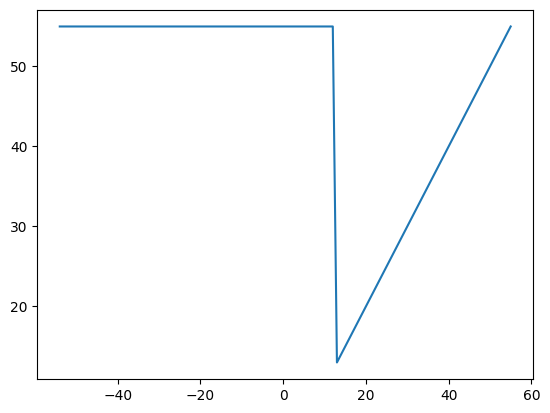

In [98]:
# If K increases we will want to do bigger orders, and fewer orders as the cost of ordering is higher, thus the discontinuity in the graph
# will move to the left, as we will have a lower s*_t

theta, y_t = get_dp(K=80)
for t in range(1, T + 1):
    S_t = y_t[t][np.min(x_range)]
    # get index of the last element that is equal to S_t
    for x in x_range:
        if y_t[t][x] == S_t:
            s_t = x
        else:
            break
    print(f"S*_{t:<2}={S_t:^4} s*_{t:<2}={s_t}")
plt.plot(x_range, [y_t[6][x] for x in x_range])